In [18]:
# project_path = './gdrive/'
# import os
# os.chdir('./gdrive/My Drive/Hands_data')

/content/gdrive/My Drive/Hands_data


In [0]:
# Unrar file
# get_ipython().system_raw("unrar x rock_paper_scissors.rar")

In [38]:
%load_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import math
from utils import utils
from pathlib import Path
import functools
from IPython.core.debugger import set_trace
#%Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Lambda, Conv2D, Conv2DTranspose, 
Dropout, MaxPooling2D, LeakyReLU, concatenate, BatchNormalization)
# Some hyper-parameters:
batch_size  = 32            # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 300           # Max number of training epochs
random_seed = 42            # Seed for some random operations, for reproducibility

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Preprocessing

In [39]:
train_path = Path('./data/rock_paper_scissors/rps')
test_path = Path('./data/rock_paper_scissors/rps-test-set/')

### Data Loading

In [40]:
train_list_ds = tf.data.Dataset.list_files(str(train_path/'*/**'))
val_list_ds = tf.data.Dataset.list_files(str(test_path/'*/**'))

In [41]:
num_train_imgs = utils.count(train_list_ds)
print(f'The number of train images is: {num_train_imgs}')
num_val_imgs = utils.count(val_list_ds)
print(f'The number of val images is: {num_val_imgs}')

The number of train images is: 2520
The number of val images is: 372


### Data Processing

Since our goal is to get better quality images from lower ones, we will lower the quality of images in our dataset before feeding into the model

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def _prepare_data_fn(file_path, scale_factor=4, augment=True,
                     return_batch_as_tuple=True, seed=None):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    # Convert the images to float type, also scaling their values from [0, 255] to [0., 1.]:
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Computing the scaled-down shape:
    original_shape = tf.shape(image)
    original_size = original_shape[-3:-1]
    scaled_size = original_size // scale_factor
    # Just in case the original dimensions were not a multiple of `scale_factor`,
    # we slightly resize the original image so its dimensions now are
    # (to make the loss/metrics computations easier during training):
    original_size_mult = scaled_size * scale_factor
    
    # Opt. augmenting the image:
    if augment:
        original_shape_mult = (original_size_mult, [tf.shape(image)[-1]])
        if len(image.shape) > 3: # batched data:
            original_shape_mult = ([tf.shape(image)[0]], *original_shape_mult)
        original_shape_mult = tf.concat(original_shape_mult, axis=0)
        
        # Randomly applied horizontal flip:
        image = tf.image.random_flip_left_right(image)

        # Random B/S changes:
        image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed)
        image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check

        # Random resize and random crop back to expected size:
        random_scale_factor = tf.random.uniform([1], minval=1.0, maxval=1.2, 
                                                dtype=tf.float32, seed=seed)
        scaled_height = tf.cast(tf.multiply(tf.cast(original_size[0], tf.float32), 
                                            random_scale_factor), 
                                tf.int32)
        scaled_width = tf.cast(tf.multiply(tf.cast(original_size[1], tf.float32), 
                                           random_scale_factor), 
                               tf.int32)
        scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))
        image = tf.image.resize(image, scaled_shape)
        image = tf.image.random_crop(image, original_shape, seed=seed)
    
    # Generating the data pair for super-resolution task, 
    # i.e. the downscaled image + its original version
    image_downscaled = tf.image.resize(image, scaled_size)
    
    # Just in case the original dimensions were not a multiple of `scale_factor`,
    # we slightly resize the original image so its dimensions now are
    # (to make the loss/metrics computations easier during training):
    original_size_mult = scaled_size * scale_factor
    image = tf.image.resize(image, original_size_mult)
    
    features = (image_downscaled, image) if return_batch_as_tuple else {'image': image_downscaled,
                                                                        'label': image}
    return features

def get_hands_dataset(ds_list, scale_factor=4, batch_size=32, num_epochs=None, 
                    shuffle=True, augment=False, return_batch_as_tuple=True, 
                    seed=None):
    prepare_data_fn = functools.partial(
        _prepare_data_fn, scale_factor=4, augment=True,
        return_batch_as_tuple=True, seed=None)
    hands_dataset = ds_list.map(prepare_data_fn, num_parallel_calls=AUTOTUNE)
    hands_dataset = hands_dataset.batch(batch_size)
    hands_dataset = hands_dataset.prefetch(AUTOTUNE)
    return hands_dataset

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_hands_dataset = get_hands_dataset(train_list_ds)
val_hands_dataset = get_hands_dataset(val_list_ds)    

In [44]:
val_input, val_target = next(iter(val_hands_dataset))


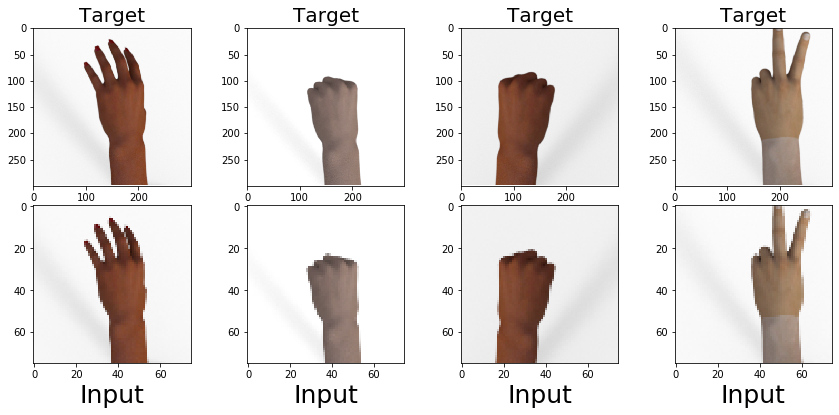

In [45]:
def show_im(inputs, targets, no=5):
    """Show images for comparison"""
    fig = plt.figure(figsize=(15,10))
    for idx, (inp, target) in enumerate(zip(inputs, targets)):
        while idx + 1 <=no:
            ax1 = fig.add_subplot(1,no+1,idx+1)
            ax2 = fig.add_subplot(2,no+1,idx+1)
            ax1.imshow(inputs[idx].numpy())
            ax1.set_xlabel('Input', fontsize=25)
            ax2.imshow(targets[idx].numpy())
            ax2.set_title('Target', fontsize=20)
            break
    plt.tight_layout()
show_im(val_input, val_target, 4)

The input images show what our low quality images look like. The target images are what we aim for our model to produce. Peak Signal-to-Noise Ratio (PSNR) compares the quality of the two images. The higher the PSNR, the more similar the two images are in terms of quality. We'll compute the psnr of the original vs our low quality images.

In [46]:
psnr_val = tf.convert_to_tensor([], dtype=tf.float32)
for v_images_input, v_images_target in val_hands_dataset:
    v_images_input = tf.image.resize(v_images_input, tf.shape(v_images_target)[1:3])
    val_psnr_result = tf.image.psnr(v_images_target, v_images_input, max_val=1.)
    
    psnr_val = tf.concat((psnr_val, val_psnr_result), axis=0)
    
num_images = psnr_val.shape[0]
psnr_val = tf.reduce_mean(psnr_val).numpy()
print("Avg PSNR using default `tf.image.resize_images()` to scale up the {} val images: {}".format(
    num_images, psnr_val))

Avg PSNR using default `tf.image.resize_images()` to scale up the 372 val images: 32.68239974975586


The avg psnr between the original and lower quality images is ~32.60. Since we want to reconstruct better quality images from lower quality ones, our goal is, therefore, to get avg psnr between our reconstructed images and original ones to be greater than 32.60

### U-net Auto-Encoder

We'll build a deep auto-encoder for our reconstruction purposes using the U-net architecture

In [55]:
from IPython.core.display import Image

#### U-net Architecture

Below image shows the architecture of U-net. The first 4 blocks, excluding the Input layer, to the left are the encoder block while those on the right are the decoder block. There's a bottlekneck layer in the middle. Each block consists of two Conv2d and a Maxpool2d layer. After each Conv2d layer, the output will be normalized. After each Maxpool2d layer, the number of neurons increases by 2 for the encoder block and decreases by 2 for the decoder one. The decoder block, however, will be fed inputs that are concatenated from the output of the symmetrical block to its position and its previous layer output. The final layer is a Conv2D with N = D (the number of channels the original image has).

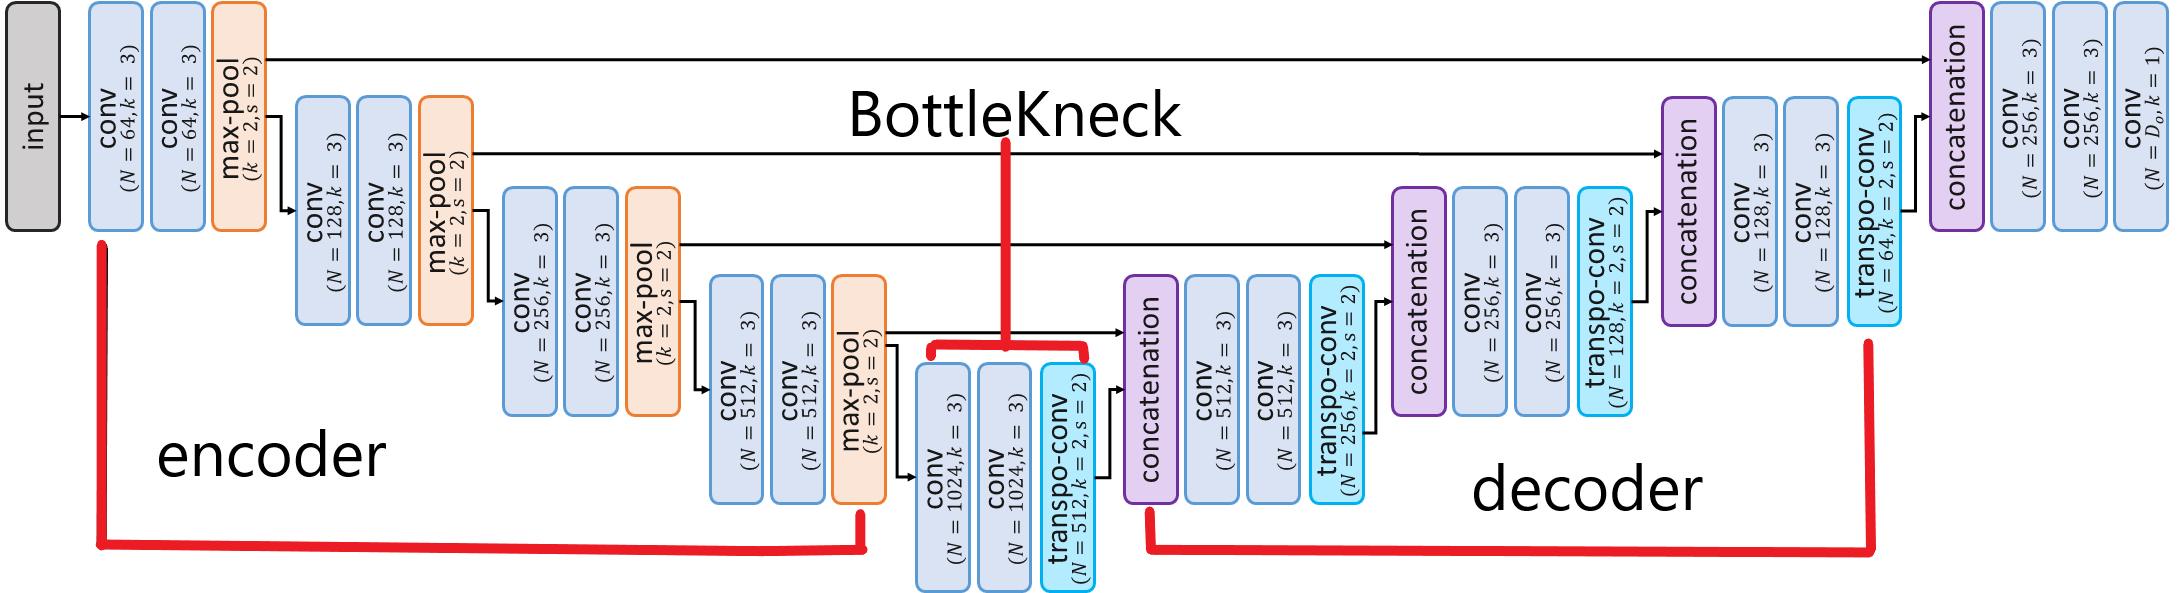

In [56]:
Image('./images/unet-detailed.png')

In [49]:
# Network hyper-parameters:
scale_factor = 4
kernel_size  =  4
filters_orig = 64
layer_depth  =  4
use_batch_norm = batch_size > 1

Before feeding images to our auto-encoder, we need to rescale our images to their original shape. The Upscale layer does exactly what we want. 

We'll create a function that generate each block of the encoder. One conv block of the encoder contains a Conv2d layers, followed by a BatchNorm layer. An encoder block contains 2 conv blocks and 1 Maxpool2d at the end. We'll use the LeakyRelu activation function instead of the Relu one.

In [50]:
def name_layer_factory(num=0, name_prefix="", name_suffix=""):
    """
    Helper function to name all our layers.
    """
    def name_layer_fn(layer):
        return f'{name_prefix}{layer}{name_suffix}-{num}'
    
    return name_layer_fn

# Conv block 
def conv_bn_lrelu(filters, kernel_size=3, batch_norm=True,
                  kernel_initializer='he_normal', padding='same',
                  name_fn=lambda layer: "conv_bn_lrelu-{}".format(layer)):
    """Conv block for encoder: a conv2d layer with batchnorm and leaky relu activation function"""
    def block(x):
        x = Conv2D(filters, kernel_size=kernel_size, 
                   activation=None, kernel_initializer=kernel_initializer, 
                   padding=padding, name=name_fn('conv'))(x)
        if batch_norm:
            x = BatchNormalization(name=name_fn('bn'))(x)
        x = LeakyReLU(alpha=0.3, name=name_fn('act'))(x)
        return x
    
    return block

# Encoder block
def unet_conv_block(filters, kernel_size=3,
                    batch_norm=True, dropout=False, 
                    name_prefix="enc_", name_suffix=0):
    """Creating the Encoder Block with 2 Conv2D layers and a Batchnorm after each block"""
    def block(x):
        # First convolution:
        name_fn = name_layer_factory(1, name_prefix, name_suffix)
        x = conv_bn_lrelu(filters, kernel_size=kernel_size, batch_norm=batch_norm, 
                          name_fn=name_layer_factory(1, name_prefix, name_suffix))(x)
        if dropout:
            x = Dropout(0.2, name=name_fn('drop'))(x)

        # Second convolution:
        name_fn = name_layer_factory(2, name_prefix, name_suffix)
        x = conv_bn_lrelu(filters, kernel_size=kernel_size, batch_norm=batch_norm, 
                          name_fn=name_layer_factory(2, name_prefix, name_suffix))(x)
        
        return x
    
    return block

Encoder architecture contains 4 encoder blocks, each followed by a MaxPool2D layer. Starting with 64 neurons, the number doubles after each block to 512 in the last block. 

The bottlekneck layer contains two Conv2d layers followed by BatchNorm. We can reuse our unt_conv_block function to generate this layer

In [51]:
Upscale = lambda name: Lambda(
    lambda images: tf.image.resize(images, tf.shape(images)[-3:-1] * scale_factor), 
    name=name)

In [54]:
# Before feeding encoder's outputs to the decoder, we need to resize the images into the original shape
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize(images[0], tf.shape(images[1])[-3:-1]), 
    name=name)


def unet(x, layer_depth=4, filters_orig=32, kernel_size=4, 
         batch_norm=True, dropout=True, final_activation='sigmoid'):
    """
    Define a U-Net network.
    
    Input
    -----
        x:  array-like
            Input tensor/placeholder
        filters_orig: int
            Number of filters for the 1st CNN layer
        kernel_size:  int 
            Kernel size for the convolutions
        batch_norm: bool
            If True, perform batch normalization
        dropout: bool 
            If True, perform dropout
        final_activation: str
            Name of activation function for the final layer
    Output
    ------
        Network (Keras Functional API)
    """
    num_channels = x.shape[-1]
    
    # Encoding layers:
    filters = filters_orig
    outputs_for_skip = []
    for i in range(layer_depth):
        
        # Convolution block:
        x_conv = unet_conv_block(filters, kernel_size, 
                                 dropout=dropout, batch_norm=batch_norm, 
                                 name_prefix="enc_", name_suffix=i)(x)
        
        # We save the pointer to the output of this encoding block,
        # to pass it to its parallel decoding block afterwards:
        outputs_for_skip.append(x_conv)

        # Downsampling:
        x = MaxPooling2D(2)(x_conv)

        filters = min(filters * 2, 512)

    # Bottleneck layers:
    x = unet_conv_block(filters, kernel_size, dropout=dropout, 
                        batch_norm=batch_norm, name_suffix='_btleneck')(x)

    # Decoding layers:
    for i in range(layer_depth):
        filters = max(filters // 2, filters_orig)

        # Upsampling:
        name_fn = name_layer_factory(3, "ups_", i)
        x = Conv2DTranspose(filters, kernel_size=kernel_size, strides=2, 
                            activation=None, kernel_initializer='he_normal', 
                            padding='same', name=name_fn('convT'))(x)
        if batch_norm:
            x = BatchNormalization(name=name_fn('bn'))(x)
        x = LeakyReLU(alpha=0.3, name=name_fn('act'))(x)
    
        # Concatenation with the output of the corresponding encoding block:
        shortcut = outputs_for_skip[-(i + 1)]
        x = ResizeToSame(name='resize_to_same{}'.format(i))([x, shortcut])
        
        x = concatenate([x, shortcut], axis=-1, name='dec_conc{}'.format(i))

        # Convolution block:
        use_dropout = dropout and (i < (layer_depth - 2))
        x = unet_conv_block(filters, kernel_size, 
                            batch_norm=batch_norm, dropout=use_dropout,
                            name_prefix="dec_", name_suffix=i)(x)

    # x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', 
    #            padding='same', name='dec_out1')(x)  
    # x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', 
    #            padding='same', name='dec_out2')(x)    
    x = Conv2D(filters=num_channels, kernel_size=1, activation=final_activation, 
               padding='same', name='dec_output')(x)
    
    return x
  
inputs = Input(shape=(None, None, 3), name='input')
resized_inputs = Upscale(name='upscale_input')(inputs)

outputs = unet(resized_inputs, layer_depth, filters_orig, kernel_size, use_batch_norm)

unet_model = Model(inputs, outputs)
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
upscale_input (Lambda)          (None, None, None, 3 0           input[0][0]                      
__________________________________________________________________________________________________
enc_conv0-1 (Conv2D)            (None, None, None, 3 1568        upscale_input[0][0]              
__________________________________________________________________________________________________
enc_bn0-1 (BatchNormalization)  (None, None, None, 3 128         enc_conv0-1[0][0]                
____________________________________________________________________________________________

In [53]:
callbacks  = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',
                                     restore_best_weights=True)]

# Compilation:
psnr_metric = functools.partial(tf.image.psnr, max_val=1.)
psnr_metric.__name__ = 'psnr'
optimizer = tf.optimizers.Adam(learning_rate=1e-4)
unet_model.compile(optimizer=optimizer, loss='mae', metrics=[psnr_metric])


train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)


history_unet = unet_model.fit(
    train_hands_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_hands_dataset, validation_steps=val_steps_per_epoch,
    verbose=1, callbacks=callbacks)

Train for 79 steps, validate for 12 steps
Epoch 1/300
 1/79 [..............................] - ETA: 24:29WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 


ResourceExhaustedError:  OOM when allocating tensor with shape[32,150,150,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/enc_bn1-2/FusedBatchNormV3-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_35769]

Function call stack:
distributed_function


In [0]:
unet_model.save('unet_model.h5')

In [58]:
history_unet.history.keys()

dict_keys(['loss', 'psnr', 'val_loss', 'val_psnr'])

### Evaluation

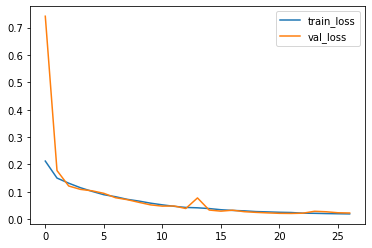

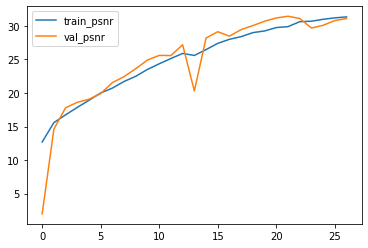

In [61]:
train_loss = history_unet.history['loss']
val_loss = history_unet.history['val_loss']
train_psnr = history_unet.history['psnr']
val_psnr = history_unet.history['val_psnr']
x = range(0, len(train_loss))
plt.figure()
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, val_loss, label='val_loss')
plt.legend()

plt.figure()
plt.plot(x, train_psnr, label='train_psnr')
plt.plot(x, val_psnr, label='val_psnr')
plt.legend()

In [0]:
val_images_pred = unet_model.predict(val_input)

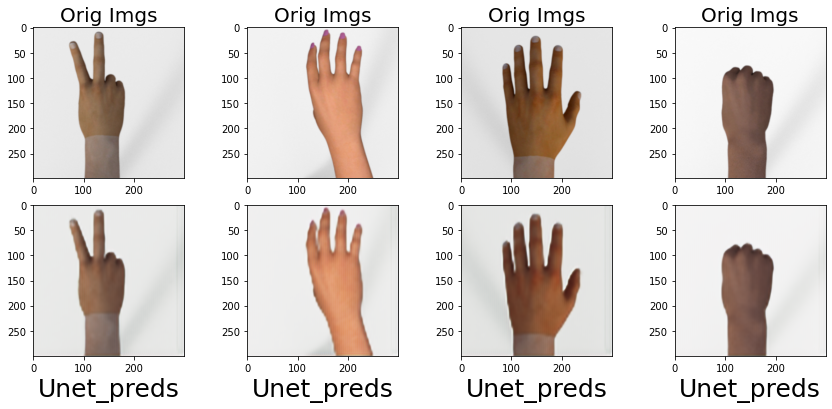

In [68]:
def show_im(inputs, targets, label1, label2, no=5):
    """Show images for comparison"""
    fig = plt.figure(figsize=(15,10))
    for idx, (inp, target) in enumerate(zip(inputs, targets)):
        while idx + 1 <=no:
            ax1 = fig.add_subplot(1,no+1,idx+1)
            ax2 = fig.add_subplot(2,no+1,idx+1)
            ax1.imshow(inputs[idx])
            ax1.set_xlabel(label1, fontsize=25)
            ax2.imshow(targets[idx])
            ax2.set_title(label2, fontsize=20)
            break
    plt.tight_layout()
show_im(val_images_pred, val_target.numpy(), label1 = 'Unet_preds', label2 = 'Orig Imgs', no= 4)

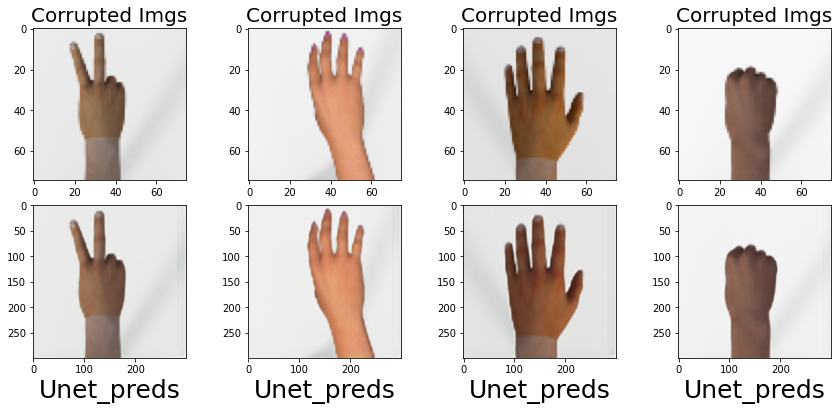

In [69]:
show_im(val_images_pred, val_input.numpy(), label1 = 'Unet_preds', label2 = 'Corrupted Imgs', no= 4)

The Unet autoencoder did enhance the quality of the corrupted images. However, the quality is not as close as what we want to achieve. 